
# Data loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


In [2]:
label_full = pd.read_pickle('label_full.pkl')
fiducial_pt_full = pd.read_pickle('fiducial_pt_full.pkl')

# Split the dataset into train, validation and test sets

In [3]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(fiducial_pt_full, label_full, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=66)

bool_train_labels = y_train != 0

# form np arrays of labels
y_train = np.array(y_train)
y_test = np.array(y_test)
#y_val = np.array(y_val)

In [4]:
# form np arrays of features
# pairwise distance calculation (can replace it with other feature engineering procedure)

# extract pairwise distance as features (78*77/2=3003 features)
# nrow=number of records of the dataset; ncol=3003
import warnings
warnings.filterwarnings('ignore')
start_time = time.time()
feature_train = np.stack((pairwise_distances(X_train[i])[np.triu_indices(78, k = 1)] for i in range(X_train.shape[0])))
print('Training feature extraction takes %s seconds.'%round((time.time()-start_time),3))

# start_time = time.time()
# feature_val = np.stack((pairwise_distances(X_val[i])[np.triu_indices(78, k = 1)] for i in range(X_val.shape[0])))
# print('Validation feature extraction takes %s seconds.'%round((time.time()-start_time),3))


start_time = time.time()
feature_test = np.stack((pairwise_distances(X_test[i])[np.triu_indices(78, k = 1)] for i in range(X_test.shape[0])))
print('Test feature extraction takes %s seconds.'%round((time.time()-start_time),3))


Training feature extraction takes 1.167 seconds.
Test feature extraction takes 0.278 seconds.


# Oversample the minority class using Numpy

Balance the dataset manually by choosing the right number of random indices from the positive examples 

In [5]:
pos_features = feature_train[bool_train_labels]
neg_features = feature_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [6]:
pos_labels.shape, neg_labels.shape

((459,), (1941,))

In [7]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(1941, 3003)

In [10]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape, resampled_labels.shape

((3882, 3003), (3882,))

## Oversample the minority using tensorflow dataset


In [ ]:
BUFFER_SIZE = 1000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [31.67663332 21.20858502 10.50377562 ... 45.254247   97.79595587
 52.54373323]

Label:  1


In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
# check if dataset is balanced
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5625


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*len(y_train==0)/BATCH_SIZE)
resampled_steps_per_epoch

120.0



# Neural Network 

In [17]:
METRICS = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall')
]
INPUT_SHAPE=[3003]
model1 = keras.Sequential([
                           keras.layers.BatchNormalization(input_shape=INPUT_SHAPE, 
                                                           momentum=0.80),
                           keras.layers.Dense(1024, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3),
                           keras.layers.Dense(512, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3),
                           keras.layers.Dense(256, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dense(128, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3),
                           keras.layers.Dense(64, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.25),
                           keras.layers.Dense(32, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.1),
                           keras.layers.Dense(16, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(
      #optimizer=keras.optimizers.RMSprop(),
      optimizer=keras.optimizers.Adam(lr=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3003)              12012     
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              3076096   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [18]:
# fit model with Numpy dataset

start_time = time.time()

EPOCHS = 100
#BATCH_SIZE = 64

resampled_history = model1.fit(
    resampled_features, resampled_labels,
    epochs=EPOCHS,
    batch_size=64, 
    callbacks = [early_stopping],
    validation_split=0.2
    )

print("training  model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/100
49/49 [==============================] - 3s 68ms/step - loss: 0.8541 - accuracy: 0.5188 - auc: 0.5156 - precision: 0.5222 - recall: 0.4913 - val_loss: 0.6923 - val_accuracy: 0.5135 - val_auc: 0.5145 - val_precision: 0.5111 - val_recall: 0.2408
Epoch 2/100
49/49 [==============================] - 3s 59ms/step - loss: 0.7316 - accuracy: 0.5092 - auc: 0.5105 - precision: 0.5113 - recall: 0.5080 - val_loss: 0.6977 - val_accuracy: 0.5006 - val_auc: 0.4532 - val_precision: 0.4464 - val_recall: 0.0654
Epoch 3/100
49/49 [==============================] - 3s 60ms/step - loss: 0.7153 - accuracy: 0.5118 - auc: 0.5179 - precision: 0.5153 - recall: 0.4644 - val_loss: 0.6941 - val_accuracy: 0.5199 - val_auc: 0.5149 - val_precision: 0.5125 - val_recall: 0.4843
Epoch 4/100
49/49 [==============================] - 3s 59ms/step - loss: 0.7091 - accuracy: 0.5082 - auc: 0.5137 - precision: 0.5101 - recall: 0.5170 - val_loss: 0.6916 - val_accuracy: 0.5290 - val_auc: 0.5417 - val_precision: 0.52

In [ ]:
# fit model with tensorflow dataset

# val_ds = tf.data.Dataset.from_tensor_slices((feature_val, y_val)).cache()
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

# start_time = time.time()

# resampled_history = model1.fit(
#     resampled_ds,
#     epochs=EPOCHS,
#     steps_per_epoch=resampled_steps_per_epoch,
#     callbacks = [early_stopping],
#     validation_data=val_ds
#     )

# print("training  model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/100
120/120 [==============================] - 6s 47ms/step - loss: 0.8275 - accuracy: 0.5003 - auc: 0.4943 - precision: 0.5003 - recall: 0.4479 - val_loss: 0.7162 - val_accuracy: 0.4604 - val_auc: 0.5052 - val_precision: 0.1919 - val_recall: 0.5652
Epoch 2/100
120/120 [==============================] - 5s 44ms/step - loss: 0.7196 - accuracy: 0.5013 - auc: 0.4995 - precision: 0.5151 - recall: 0.6253 - val_loss: 0.7149 - val_accuracy: 0.2917 - val_auc: 0.5140 - val_precision: 0.1946 - val_recall: 0.8587
Epoch 3/100
120/120 [==============================] - 5s 44ms/step - loss: 0.7064 - accuracy: 0.4992 - auc: 0.5031 - precision: 0.4978 - recall: 0.6559 - val_loss: 0.6872 - val_accuracy: 0.4958 - val_auc: 0.4897 - val_precision: 0.1739 - val_recall: 0.4348
Epoch 4/100
120/120 [==============================] - 5s 44ms/step - loss: 0.7009 - accuracy: 0.5161 - auc: 0.5166 - precision: 0.5053 - recall: 0.5569 - val_loss: 0.7061 - val_accuracy: 0.1937 - val_auc: 0.5163 - val_precisi

In [19]:
# calculate weighted accuracy on test data
pred_prob = model1.predict(feature_test).reshape(len(y_test))
pred_test = np.zeros(len(y_test))
pred_test[pred_prob>0.5] = 1

weight_test = np.zeros(len(y_test))
for v in np.unique(y_test):
    weight_test[y_test==v] = 0.5*len(y_test)/np.sum(y_test==v)
weighted_acc = np.sum(weight_test * (pred_test==y_test)/np.sum(weight_test))

In [20]:
eval = model1.evaluate(feature_test, y_test)
print('Test accuracy: {:.2f}'.format(eval[1]))
print('Test weighted accuracy: {:.2f}'.format(weighted_acc))
print('Test auc: {:.2f}'.format(eval[2]))

19/19 [==============================] - 0s 9ms/step - loss: 0.4353 - accuracy: 0.7833 - auc: 0.8384 - precision: 0.5257 - recall: 0.6619
Test accuracy: 0.78
Test weighted accuracy: 0.74
Test auc: 0.84


In [21]:
# save the model, download manually
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)
model1.save(export_path_keras)

./1604421126.h5


In [ ]:
# load model
import tensorflow_hub as hub
m = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

#new_model = tf.keras.models.load_model('NN.h5')

#m.summary()

In [ ]:
# calculate weighted accuracy on test data
pred_prob = m.predict(feature_test).reshape(len(y_test))
pred_test = np.zeros(len(y_test))
pred_test[pred_prob>0.5] = 1

weight_test = np.zeros(len(y_test))
for v in np.unique(y_test):
    weight_test[y_test==v] = 0.5*len(y_test)/np.sum(y_test==v)
weighted_acc = np.sum(weight_test * (pred_test==y_test)/np.sum(weight_test))

In [ ]:
eval = m.evaluate(feature_test, y_test)
print('Test accuracy: {:.2f}'.format(eval[1]))
print('Test weighted accuracy: {:.2f}'.format(weighted_acc))
print('Test auc: {:.2f}'.format(eval[2]))

19/19 [==============================] - 0s 9ms/step - loss: 0.5532 - accuracy: 0.7483 - auc: 0.8251 - precision: 0.4714 - recall: 0.7122
Test accuracy: 0.75
Test weighted accuracy: 0.74
Test auc: 0.83


In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['auc', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

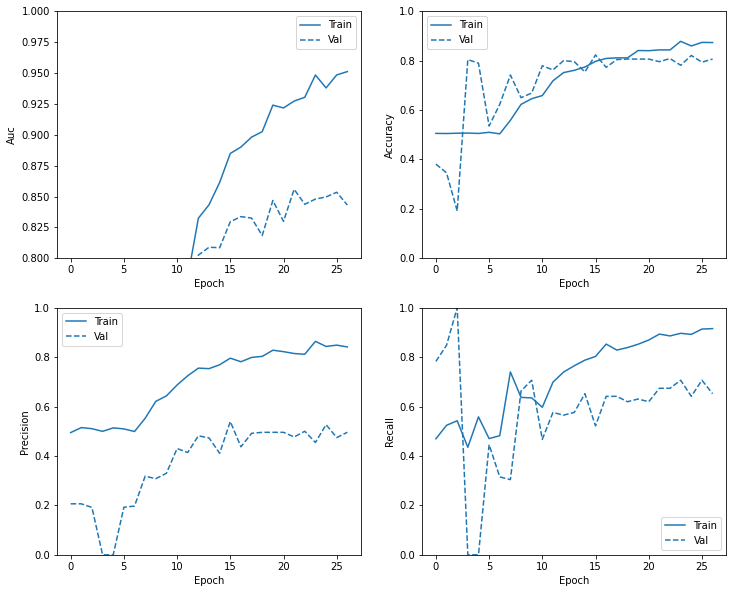

In [ ]:
plot_metrics(resampled_history)